<h1><center>Laboratorio 6: La desperación de Mr. Lepin 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Matías Rojas y Mauricio Araneda
- Auxiliar: Ignacio Meza D.
- Ayudante: Rodrigo Guerra

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Vanessa Gaete
- Nombre de alumno 2:


### **Link de repositorio de GitHub:** `https://github.com/VanessaGaete/Laboratorio-de-Ciencia-de-Datos`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

# Temas a tratar

- Aplicar Pandas para obtener características de un DataFrame.
- Aplicar Pipelines.
- Aplicar Clusters sobre un conjunto de datos.

## Reglas:

- Fecha de entrega: 09/06/2021
- **Grupos de 2 personas**
- **Ausentes** deberán realizar la actividad solos. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Comprender y aprovechar las ventajas que nos ofrece la librería `pandas` con respecto a trabajar en Python 'puro'.
- Crear nuevas características para entrenar un modelo de clustering.
- Comprender como aplicar pipelines de Scikit-Learn para generar procesos más limpios.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [25]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from IPython.display import HTML

# Libreria para plotear (En colab esta desactualizado plotly)
!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerias utiles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except: 
    print('Ignorando conexión drive-colab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin, en una nueva reunión, le cuenta a ud y su equipo que los resultados derivados del análisis exploratorio de dato presentaron una gran utilidad para la empresa y que tiene un gran entusiasmo por continuar trabajando con ustedes.
Es por esto, que Mr. Lepin les pide que cargue y visualicen algunas de las filas que componen el Dataset.
A continuación un extracto de lo parlamentado en la reunión:

    - Usted: Es un gran logro para nuestro equipo que usted haya encontrado excelente el EDA. ¿Qué tiene en mente ahora?
    - Mr. Lepin: Resulta que hace algún tiempo, mientras tomaba un mojito en una reunión de gerentes en Panamá, oí a un *chato* acerca de **LRMFP**, que es un modelo que permite personificar a los clientes a través de la farbicación de distintos atributos que describen a los clientes. Lo encontré es-tu-pendo ñatito. 
    - Usted: Ehh bueno. Investigaremos acerca de este modelo y veremos lo que podemos hacer.

Por ende, su siguiente tarea es calcular **LRMFP** sobre cada cliente y luego hacer un análisis de las características generadas. Para esto, el área de ventas les entrega un nuevo archivo llamado `online_retail_II_cleaned.pickle`, quien posee los datos del DataFrame original limpios y listos para obtener las características solicitadas por Mr. Lepin.

In [27]:
df_retail = pd.read_pickle("online_retail_II_cleaned.pickle")
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": "category",
        "Description": str,
        "Customer ID": "category",
        "Country": "category"
    }
)
df_retail.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 1.2 Creación de nuevas Caracteristicas [2 Puntos] 

Como ya se les comento, Mr. Lepin esta interesado en obtener las características **LRMFP**, para esto les señala que estas características se construyen en base a las siguientes definiciones:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.
- **Recency (R)**: Indica la actualidad de la interacción de un cliente con la empresa, y da información sobre la tendencia a repetir la compra. Se define como: 
$$Recency(n)=\dfrac{1}{n} \sum^n_{i=1} date\_diff(t_{fecha final}, t_{m-i+1})$$

 Donde $date\_diff$ representa la diferencia en días entre la fecha de finalización del periodo de observación ($t_{fecha final}$), y la fecha de una visita del cliente cercana a $t_{fecha final}$, $t_{m-i+1}; t_{m}$ es la última visita del cliente; y n es el número de visitas recientes del cliente consideradas.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

$$Periodicity(n)=std(IVT_1, ..., IVT_n)$$

&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Donde $IVT$ denota el tiempo entre visitas y n representa el número de valores de tiempo entre visitas de un cliente.
 

$$IVT_i=date\_diff(t_{i+1},t)$$

En base a las definiciones señaladas, diseñe una función que permita obtener las características **LRMFP** recibiendo un DataFrame como entrada. Para esto, no estará permitido el uso de iteradores, utilice todas las herramientas que les ofrece `pandas` para realizar esto.

Una referencia que le puede ser útil es el [documento original](https://www.researchgate.net/publication/315979555_LRFMP_model_for_customer_segmentation_in_the_grocery_retail_industry_a_case_study) en donde se propone este método.

**Nota:** Para la $fechafinal$ utilice la fecha máxima del dataset más 1 día.

**Ejemplo de Resultado Esperado:**

| Customer ID | Length | Recency | Frequency | Monetary | Periodicity |
|------------:|-------:|--------:|----------:|---------:|------------:|
|   12346.0   |    294 |      67 |        46 |   -64.68 |        37.0 |
|   12347.0   |     37 |       3 |        71 |  1323.32 |         0.0 |
|   12349.0   |    327 |      43 |       107 |  2646.99 |        78.0 |
|   12352.0   |     16 |      11 |        18 |   343.80 |         0.0 |
|   12356.0   |     44 |      16 |        84 |  3562.25 |        12.0 |

**Respuesta:**

In [28]:
def recency(n, dataframe_in):
  #dataframe_out = pd.DataFrame(columns = ["Customer ID", "Max Invoice Dates"])
  df=pd.DataFrame()
  df["CustomerID"] = dataframe_in["Customer ID"]
  df["Invoice"] = dataframe_in["Invoice"]
  df["InvoiceDate"]= dataframe_in["InvoiceDate"]
  df_without_duplicates = df.drop_duplicates(subset=['Invoice'])
  df = df_without_duplicates.groupby(["CustomerID"])["InvoiceDate"].nlargest(n)

  #date_diff
  tfinal = dataframe_in["InvoiceDate"].max() + datetime.timedelta(days=1)
  df = abs(df - tfinal).apply(lambda x: x.days)
  #print(df.index.get_level_values('CustomerID'))

  #sum()
  df = df.groupby(["CustomerID"]).sum()
  df = df*(1/n)

  df_recency = pd.DataFrame()
  df_recency["CustomerID"] = df.keys()
  df_recency["Recency"] = df.values

  return df_recency
  #result = 1/n*sum()

recency(3, df_retail)

,CustomerID,Recency
0,12346.0,256.666667
1,12347.0,14.333333
2,12348.0,24.666667
3,12349.0,158.000000
4,12351.0,3.666667
...,...,...
4309,18283.0,49.666667
4310,18284.0,22.333333
4311,18285.0,98.666667
4312,18286.0,157.000000


In [29]:
import statistics
import numpy as np

def periodicity(dataframe_in):
  df_periodicity= pd.DataFrame()

  df_without_duplicates = dataframe_in.drop_duplicates(subset=['Invoice'])
  df = df_without_duplicates.groupby(["Customer ID"])["InvoiceDate"].agg(lambda x: x.diff())
  df = df.apply(lambda x: x.days)
  df = df.apply(lambda x: np.delete(x, 0))
  df_periodicity["n"] = df.apply(lambda x: len(x))

  df = df.apply(lambda x: np.std(x))

  df_periodicity["CustomerID"] = df.keys()
  df_periodicity["Periodicity"] = df.values

  df_periodicity['Periodicity'] = df_periodicity.apply(
    lambda row: row.Periodicity if row.n > 1 else -1 , axis=1)

  return df_periodicity

periodicity(df_retail)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning:

Degrees of freedom <= 0 for slice



,n,CustomerID,Periodicity
Customer ID,,,
12346.0,10,12346.0,34.778729
12347.0,1,12347.0,-1.000000
12348.0,0,12348.0,-1.000000
12349.0,2,12349.0,72.000000
12351.0,0,12351.0,-1.000000
...,...,...,...
18283.0,5,18283.0,55.304973
18284.0,0,18284.0,-1.000000
18285.0,0,18285.0,-1.000000


In [30]:
def custom_features(dataframe_in):
    dataframe_out = pd.DataFrame(columns = ["CustomerID", "Length", "Recency", "Frecuency", "Monetary", "Periodicity"])
    
    #LENGTH
    a = dataframe_in.groupby(["Customer ID"]).min()["InvoiceDate"]
    b = dataframe_in.groupby(["Customer ID"]).max()["InvoiceDate"]
    dataframe_out["CustomerID"] = a.keys()
    dataframe_out["Length"] = abs(a - b).apply(lambda x: x.days).values
    #RECENCY
    df_recency = recency(5, dataframe_in)
    dataframe_out["Recency"] = df_recency["Recency"].values

    #MONETARY
    
    #Se que este calculo esta mal, en vez de hacer esto me hubiese gustado hacer:
    #dataframe_in.groupby(["Customer ID", "Invoice"]).mean()["Price"] * dataframe_in.groupby(["Customer ID", "Invoice"]).mean()["Quantity"]
    #Y luego aplicar un promedio sobre los promedios de cada compra del cliente. Sin embargo google colab se quedaba sin ram al intentar hacer 
    #groupby de las columnas Customer ID e Invoice y no se por qué, nunca pude arreglar el error.
    dataframe_out["Monetary"] = (dataframe_in.groupby(["Customer ID"]).mean()["Price"] * dataframe_in.groupby(["Customer ID"]).mean()["Quantity"]).values

    #FRECUENCY
    dataframe_out["Frecuency"] = dataframe_in.groupby(["Customer ID"]).count()["InvoiceDate"].values

    #PERIODICITY
    df_periodicity = periodicity(dataframe_in)
    dataframe_out["Periodicity"] = df_periodicity["Periodicity"].values
    return dataframe_out

custom_features(df_retail)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning:

Degrees of freedom <= 0 for slice



,CustomerID,Length,Recency,Frecuency,Monetary,Periodicity
0,12346.0,196,288.0,33,13.264646,34.778729
1,12347.0,37,8.6,71,26.765047,-1.000000
2,12348.0,0,14.8,20,13.418675,-1.000000
3,12349.0,181,94.8,102,83.546003,72.000000
4,12351.0,0,2.2,21,29.272245,-1.000000
...,...,...,...,...,...,...
4309,18283.0,275,137.8,217,3.263627,55.304973
4310,18284.0,0,13.4,28,57.395995,-1.000000
4311,18285.0,0,59.2,12,100.895833,-1.000000
4312,18286.0,247,94.2,67,38.777100,-1.000000


**Resúesta de Pauta:**

En el caso de que la persona tenga menos de dos visitas entonces se "castiga" su periodicidad como -1.

## 1.3 Pipelines 👷

Finalmente *Don Mora* le pregunta si seria posible realizar un pipeline para realizar una segmentación de los clientes con los nuevos datos generados, a lo que usted responde que **sí** y propone la utilización de k-means para la segmentación.

A continuación siga los pasos requeridos para obtener la segmentación de clientes.

### 1.3.1 Estandarizar Caracteristicas [0.5 puntos]

Construya una clase llamada ``MinMax()`` utilizando ``BaseEstimator`` y ``TransformerMixin`` para realizar una transformación de cada una de las columnas de un DataFrame utilizando ``ColumnTransformer()`` más tarde (tome como referencia el siguiente [enlace](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer)).


 Para esto considere que Min-Max escaler queda dada por la ecuación:

$$MinMax = \dfrac{x-min(x)}{max(x) - min(x)}$$

Con esto buscamos que los valores que componen a las columnas se muevan en el rango de valores $[0, 1]$.

**Respuesta:**

In [31]:
from sklearn.base import TransformerMixin

class MinMax(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
      return self
    def transform(self, X):
      minmax = (X - X.min())/(X.max() - X.min())
      return minmax

### 1.3.2 `T-SNA` Pipeline [1.0 puntos]

Para comenzar introduciéndose en el uso de pipeline, decide probar realizando un pipeline enfocado en la reducción de dimensionalidad y así hacer no decepcionar a Mr. Lepin con la clusterización del modelo. 

Configure un pipeline utilizando el algoritmo `T-SNE` sobre los datos **LRMFP**, donde, para la realización del pipeline considera los siguientes pasos:

1. Como primer paso obtenga las características **LRMFP** desde el DataFrame ``df_retail_II_cleaned.pickle`` utilizando la función ``custom_features`` creada anteriormente, junto a ``FunctionTransformer()``. Considere esto como el primer paso de su pipeline.
2. En segundo lugar usando ``ColumnTransformer()`` aplique el MinxMax scaler creado por usted sobre todas las columnas generadas en el paso anterior. 
3. Finalmente, aplique un último paso donde obtiene las 2 componentes más relevantes utilizando el algoritmo T-sne de sckit-learn.

Tras aplicar las transformaciones sobre el dataset **LRMFP**, gráfique las componentes obtenidas en la reducción de dimensionalidad.

**Respuesta:**

In [32]:
from sklearn.preprocessing import MinMaxScaler
LRMFP = FunctionTransformer(custom_features, validate=False)

pl = Pipeline(memory=None,
    steps=[
        ('LRMFP', LRMFP),
        ('scaler', MinMaxScaler()),
        ('TSNE', TSNE())
    ], verbose=True)



df_preprocesado = pl.fit_transform(df_retail)
df_preprocesado



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning:

Degrees of freedom <= 0 for slice



[Pipeline] ............. (step 1 of 3) Processing LRMFP, total=   8.9s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[Pipeline] .............. (step 3 of 3) Processing TSNE, total=  26.6s


array([[-28.864708,  -9.075451],
       [ 64.17577 ,  33.81243 ],
       [ 71.31275 ,  40.33351 ],
       ...,
       [-34.449944,  41.34082 ],
       [ 13.170742, -58.67087 ],
       [ 29.120096, -41.347492]], dtype=float32)

In [33]:
df_preprocesado = pd.DataFrame(df_preprocesado)
df_preprocesado

,0,1
0,-28.864708,-9.075451
1,64.175774,33.812431
2,71.312752,40.333511
3,-34.657059,-16.180557
4,73.379890,40.616699
...,...,...
4309,2.077670,-47.289913
4310,-42.408657,52.808136
4311,-34.449944,41.340820
4312,13.170742,-58.670872


In [34]:
import plotly.express as px

fig = px.scatter(df_preprocesado, x=0, y=1)
fig.update_layout( title="Distribución de elementos según sus nuevas caracteristicas", xaxis_title="característica 0",
    yaxis_title="caracteristica 1")
fig.show()

In [35]:
import plotly.graph_objects as go



fig = go.Figure()
fig.add_trace(go.Histogram(x=df_preprocesado[0]))
fig.add_trace(go.Histogram(x=df_preprocesado[1]))

# Overlay both histograms
fig.update_layout(barmode='overlay', title="Histograma de valores de cada nueva caracteristica", xaxis_title="frecuencia",
    yaxis_title="valor")
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

En ambos gráficos se pueden ver los datos bien distribuidos, es decir, que no tienen valores totalmente difeerentes unos de otros, que es lo que se busca.

### 1.3.3 Clustering

#### 1.3.3.1 Método del Codo [1 puntos]

Utilizando la clase creada para escalamiento, aplique el método del codo para visualizar cual es el número de clusters que mejor se ajustan a los datos. Realice esto utilizando el algoritmo K-means dentro de un pipeline para un $k \in [1,20]$, donde k representa el número de clusters del k-means. Para la realización de esta sección y la próxima (1.3.3.2), considere los mismos pasos utilizados para el t-sne, pero permutando el algoritmo de reducción de dimensionalidad por k-means.

A través del grafico obtenido, comente y justifique que valor de k escogería para realizar el k-means.

**Respuesta:**

In [36]:
RANDOM_STATE = 99


from sklearn.cluster import KMeans



intertias = [
    [i, KMeans(n_clusters=i, random_state=0).fit(df_preprocesado).inertia_]
    for i in range(2, 10)
]

intertias = pd.DataFrame(intertias, columns=["n° clusters", "inertia"])
intertias.head(10)



px.line(
    intertias,
    x="n° clusters",
    y="inertia",
    title="Método del Codo con K-Means",
    height=600,
)





Se peude ver que entre 2 y 3 hay muchas mas pendiente que entre 3 y 4. Por lo tanto 3 sería el punto de inflexión, el número de clusters óptimo.

#### 1.3.3.2 Segmentación de Clientes con K-Means 🎁 [1 punto]

En base a la elección de k realizada en la sección anterior, utilice este valor escogido y entrene un modelo de K-means utilizando el mismo pipeline de scikit-learn utilizado anteriormente.

Una vez ajustado los datos, genere una tabla con los promedios (o medianas) para cada uno de los atributos, agrupando estos por el clúster que pertenecen. ¿Es posible observar agrupaciones coherentes?, ¿Qué tipo de clientes posee el retail?, Justifique su respuesta y no decepcione a Mr. Lepin.


**Respuesta:**

In [37]:
# El número de clusters es parámetro. En este caso, es 2.
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit(df_preprocesado)

labels = kmeans.labels_



In [38]:
new_df= custom_features(df_retail)
new_df["Cluster"] = labels
new_df = new_df.groupby(["Cluster"]).mean()
new_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning:

Degrees of freedom <= 0 for slice



,Length,Recency,Frecuency,Monetary,Periodicity
Cluster,,,,,
0,247.765432,108.415546,150.681756,91.461467,32.775922
1,12.760711,31.233020,32.265413,99.620672,0.056256
2,20.279487,41.208205,34.639316,49.967018,0.008519


Se ven 3 grupos de clientes. El grupo 0 de clientes es el más común, y consta de personas que gastan más por visita, sin embargo no poseen una actividad reciente, son los que han comprado menos actualmente comparado con el resto de los grupos. Además tienen la peor periodicidad, es decir, sus visitas a la tienda no son muy regulares. 
Estas personas tienen una frecuencia mayor al resto de las personas, es decir, han ido más veces a la tienda. 

En el grupo 1 y 2 se ven Recencys y frecuencias parecidas, esto quiere decir que son similares en cuanto a lo reciente de su actividad y cantidad de visitas. Sin embargo se diferencian mucho en la cantidad de dinero que gastan en promedio por cada visita y en la periodicidad. El grupo 1 gasta más dionero en promedio, pero es menos regular que el grupo 2.

**Respuesta Esperada:**

|         | Length  | Recency   | Frequency | Monetary | Periodicity |       |
|---------|---------|-----------|----------|-------------|-------|-------|
| Cluster |         |           |          |             |       |       |
|    0    |   258.8 |      45.2 |     76.1 |      1107.7 | 107.6 |   449 |
|    1    |    76.1 |     217.6 |     45.5 |       791.7 |  14.1 |   466 |
|    2    |   368.5 |       4.8 |   2715.0 |    226621.6 |   4.2 |     4 |
|    3    |    85.3 |      45.7 |     65.8 |      1047.0 |  10.5 |   987 |
|    4    |   347.2 |      15.9 |   1658.0 |     35829.3 |   8.0 |    25 |
|    5    |   298.0 |      29.8 |    183.8 |      3639.9 |  32.0 |  1188 |

#### 1.3.3.3 Plot de K-Means 📈 [0.5 puntos]



Por último, Mr. Lepin, impaciente de no entender lo que usted intenta explicarle, le solicita que por favor muestre algún resultado "visual" de los grupos encontrados.

Para esto, grafique nuevamente las características encontradas usando `T-SNE` (no calcule de nuevo, simplemente utilice las proyecciones encontradas) y agregue las labels calculadas con kmeans como el argumento `color`.   

Comente: ¿Se separan bien los distintos clusters en la visualización?


**Respuesta:**

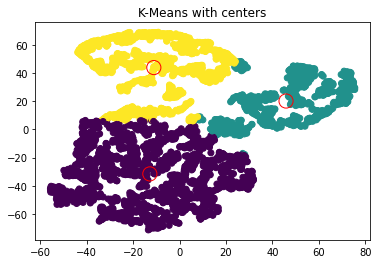

In [42]:
import matplotlib.pyplot as plt

centers = kmeans.cluster_centers_
X= df_preprocesado.to_numpy()

plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
plt.scatter(centers[:,0], centers[:,1], s=200, facecolors='none', edgecolors='r')
plt.title("K-Means with centers")
plt.show()


Se puede ver que si bien en el centro cuesta delimitar bien un límite entre los grupos (haciendo que las personas ubicadas en este lugar probablemente tengan diferencias pequeñas entre sí), sí se ve una clara distinción con en el grupo amarillo y celeste. Personalmente, hubiese ecnotrado mas correcto que ese pequeño grupo de celestes que esta pegado a los amarillos correspondiese en verdad al grupo amarillo. En ese sentido, es normal ver que algunas veces el método que se escoge no funcione de la forma que se espera. A pesar de ello, la división en general se ve correcta.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana y que **los días de atraso no se pueden utilizar para entregas de lab** solo para tareas. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>